# Intro to Stacked Series
Expanding the dimensional horizon. In the previous classification examples we always fed the transactions one-by-one, meaning we show the model exactly 1 transaction with a label and ask it to classify. That is very much how traditional Machine Learning works. Each training record is like a 1-dimensional vector with the various features as columns. 

With Neural Nets, the training records can be multi-dimensional. The data records are often called `Tensors` with a `Rank`, where the rank is the number of dimensions, traditional machine learning mainly uses rank-2 input. With the rows being the transactions and the columns being the features for the transactions. Deep Learning basically has as many ranks as you want. 

Looking at how this can work for our Fraud examples, one thing we could do is *not* just give the model 1 transaction at a time but giving it multiple transactions. For instance the last 10 transactions. Those can be stacked so we get a 2-dimensional record with the __Time__ (from T-9 till T) being the __width__ of that record and the __Features__ being the __depth/heigth__. This structure contains 10 transactions each with their features. The *Time* lines up with the columns, each column now has all the features of a transaction at a specific time. But the time is relative, for 2 specific records the first position could be a different *absolute* time. It is the time at which the T-9 payment was made. 

For these series each training 'record' is now a rank-2 tensor and if we stack them up, i.e. have multiple samples we get a rank-3 tensor, the first dimension if often referred to as the *batch* dimension. These rank-3 tensors will be used in these examples, they contain multiple samples of rank-2 stacked transactions.

There are other ways to represent a series of transactions, but let's see how this goes.

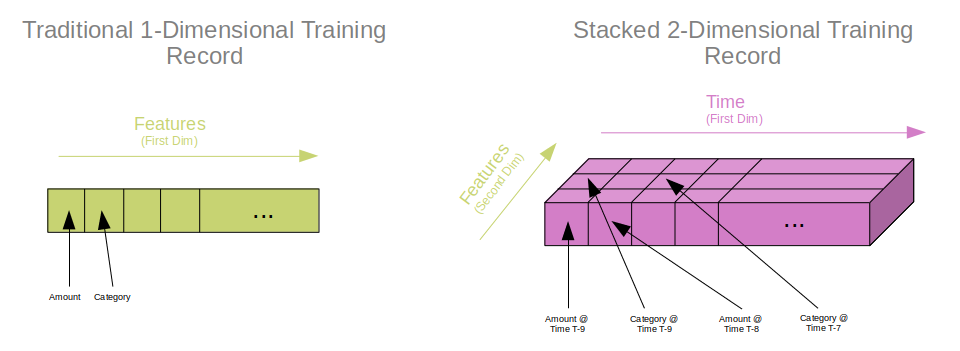

---
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import datetime as dt
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.

Two additional field from the input is used. 
- The __step__ field, in the output we can see it is an increasing integer number.
- The __customer__ identifier. We'll need this to build series per each customer. We are using the string type here rather than categorical because the values have high cardinality.

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        step,
        customer,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

with en.EnginePandasNumpy() as e:
    df = e.from_csv(base_features, file, inference=False)
    
df

2020-12-03 14:25:59.884 d373c7.engines.common          INFO     Start Engine...
2020-12-03 14:25:59.884 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2020-12-03 14:25:59.885 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-12-03 14:25:59.885 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2020-12-03 14:26:00.140 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2020-12-03 14:26:00.156 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 8)


,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0
...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,F,M1823072687,es_transportation,20.53,0
594639,179,C650108285,4,F,M1823072687,es_transportation,50.73,0
594640,179,C123623130,2,F,M349281107,es_fashion,22.44,0
594641,179,C1499363341,5,M,M1823072687,es_transportation,14.46,0


## Define some derived features
After we've defined and read the base features, we can define some __derived__ features.

The __step__ field in not all that useful, we would rather have a real date. We can convert the step field using a `FeatureExpression`, they allow us to run free-form expressions. We give it a name, a type, tell it the function to call and the parameter features to feed it. Here we assume the step is a day and add it as delta to 2020/01/01.

In the output we see we now have a date.

In [5]:
amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount)
age_oh = ft.FeatureOneHot('age_one_hot', age)
gender_oh = ft.FeatureOneHot('gender_one_hot', gender)
merchant_oh = ft.FeatureOneHot('merchant_one_hot', merchant)
category_oh = ft.FeatureOneHot('category_one_hot', category)
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)

# Function that converts a step to a date. It adds the step as days to a fixed date.
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

learning_features = ft.TensorDefinition(
    'learning', 
    [
        customer,
        date_time,
        age_oh,
        gender_oh,
        merchant_oh,
        category_oh,
        amount_scale,
        fraud_label
    ])

with en.EnginePandasNumpy() as e:
    df = e.from_df(learning_features, df, inference=False)
df

2020-12-03 14:26:02.865 d373c7.engines.common          INFO     Start Engine...
2020-12-03 14:26:02.865 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2020-12-03 14:26:02.865 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-12-03 14:26:02.866 d373c7.engines.panda_numpy     INFO     Building Panda for : <learning> from DataFrame. Inference mode <False>
2020-12-03 14:26:03.356 d373c7.engines.panda_numpy     INFO     Create amount_scale Normalize/Scale amount. Min. 0.00 Max. 8329.96
2020-12-03 14:26:03.405 d373c7.engines.panda_numpy     INFO     Done creating learning. Shape=(594643, 81)


,customer,date,age__0,age__1,age__2,age__3,age__4,age__5,age__6,age__U,...,category__es_hyper,category__es_leisure,category__es_otherservices,category__es_sportsandtoys,category__es_tech,category__es_transportation,category__es_travel,category__es_wellnessandbeauty,amount_scale,fraud_label
0,C1093826151,2020-01-01,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.000546,0
1,C352968107,2020-01-01,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.004764,0
2,C2054744914,2020-01-01,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.003228,0
3,C1760612790,2020-01-01,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0.002071,0
4,C757503768,2020-01-01,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0.004288,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594638,C1753498738,2020-06-28,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0.002465,0
594639,C650108285,2020-06-28,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.006090,0
594640,C123623130,2020-06-28,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.002694,0
594641,C1499363341,2020-06-28,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0.001736,0


## Build Series

At this point we have more or less the same set-up as the example for the FeedForward classifier, execpt that there is a date and a customer id. With these 2 new feature we can build a __stacked series__ from our data.

We call the `to_series_stacked`, we ask it to stack our *df* Pandas DataFrame, to use the customer as *key*, the *date_time* as time and *5* as length.

That will create a sort of sliding window of 5 on the transactions. It will return the transactions as a rank-2 tensor. The tensor will have the time as first dimension and the features as second dimension. 

Basically we're getting the current payment as last entry in the 1 dimension of the tensor and the 4 previous payments of that same customer pre-pending it as illustrated in the introduction

And because we have *594642* individual payments, that turns into a rank-3 tensor. Now having the batch as first dimension, the time as second dimension and the features as third dimension.

The output print shows we are getting a `NumpyList` with 3 lists, one for each learning category (binary, coninous and label) same as before. However the first 2 lists have a rank-3. The last dimension is now the features, 77 binary for the one-hot features, 1 continuous for the amount. The second dimension is 5 that is the number of payment we asked to *stack*. 

As last list in the `NumpyList` Object we still find the label. It still just has one dimension. The *label* is the label that corresponds to the __fifth (last) payment__ in the stacked series.

In [6]:
with en.EnginePandasNumpy(num_threads=8) as e:
    data_list = e.to_series_stacked(df, learning_features, key_field=customer, time_field=date_time, length=5)
print(data_list.shapes)
print(data_list.dtype_names)

2020-12-03 14:26:06.865 d373c7.engines.common          INFO     Start Engine...
2020-12-03 14:26:06.866 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2020-12-03 14:26:06.866 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-12-03 14:26:06.867 d373c7.engines.panda_numpy     INFO     Start creating stacked series for Tensor Definition <learning> using 8 process(es)
2020-12-03 14:26:13.643 d373c7.engines.panda_numpy     INFO     Returning series of types ['int8', 'float32', 'int8'].
2020-12-03 14:26:13.644 d373c7.engines.panda_numpy     INFO     Done creating learning. Shapes=[(594643, 5, 77), (594643, 5, 1), (594643, 1)]


[(594643, 5, 77), (594643, 5, 1), (594643, 1)]
['int8', 'float32', 'int8']


## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

For time-series we'll perform an additional action.
> 1. The series at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history and complete series, sometimes named 'mature' series. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

In [7]:
test_records = 100000
val_records  = 30000 
maturation   = 30000 

train_data, val_data, test_data = data_list.split_time(val_records, test_records)
# Throw away not-mature series
train_data = train_data[maturation:]

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list
gc.collect()
print('Done')

Training Data shapes [(434643, 5, 77), (434643, 5, 1), (434643, 1)]
Validation Data shapes [(30000, 5, 77), (30000, 5, 1), (30000, 1)]
Test Data shapes [(100000, 5, 77), (100000, 5, 1), (100000, 1)]
Done


## Challenge
If we want to use this in a FeedForward Neural Net, we see we have a small challenge. The `Linear Layers` are designed to have a rank-1 tensor as input. I.e. a vector. Here we have an array we would like to input, we could flatten the array out by stacking either the time or feature elements one after another, like depicted below. This operation is named *Flatten* operation.

Though that would most certainly then be a Neural Net that sees and can evaluate more than one payment at a time, intuitively we could argue that this is fairly likely to focus on very specific patterns, such as a amounts at T-9 with Categories at T-4. That might overfit and not generalize the way we would like it to. (More on over-fitting later on....) Also the Time-axis is sort of lost, the model is just free to combine any time with any other time.

Luckily, there are specific NN architectures such as Recurrent (RNN), Convolutional Layers (CNN) and Transformers specifically designed to handle multi-dimensional data. 

So we'll leave this Notebook as-is and introduce some of the fancier architectures in the next Notebooks.

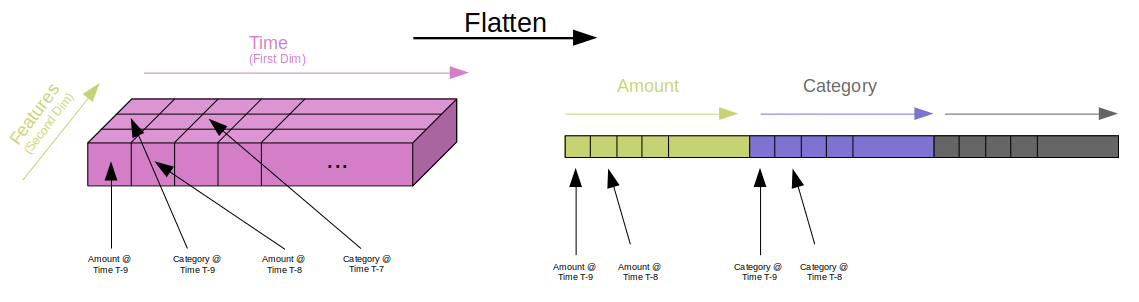

# Conclusion
In this notebook the data-structure was introduced that will be used in the next examples. It is a multi-dimensional structure where the time and feature are on different axis.